<a href="https://colab.research.google.com/github/Loki-10/VP-Detector/blob/master/EndGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!git clone https://github.com/tensorflow/models/

In [0]:
#Necessary packages are installed
!pip install pillow
!pip install lxml
!pip install Cython
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install utils
!pip install opencv-python
!pip install tensorflow-gpu
!apt-get install -qq protobuf-compiler python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive
!pip install -q pycocotools

In [0]:
%cd /content/models/research

In [0]:
#Protoc buffer files are converted into python files
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
#Sets path for Python
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

In [0]:
#Environments for tensorflow
!python3 setup.py build
#Environments for tensorflow are installed
!python3 setup.py install

In [0]:
%cd /

In [0]:
!cp -avr /content/drive/My\ Drive/object-detecting /

In [0]:
%cd /object-detecting

In [0]:
#TFrecords are created for train set
!python3 generate_tfrecord.py --csv_input=data/train_labels.csv --output_path=data/train.record --image_dir=images/train

In [0]:
#TFrecords are created for test set
!python3 generate_tfrecord.py --csv_input=data/test_labels.csv --output_path=data/test.record --image_dir=images/test

In [0]:
#Downloading faster_rcnn_inception_v2_coco_2018_01_28 model
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

In [0]:
#Extracting the model
!tar -xvzf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

In [0]:
!cp -avr /object-detecting/data /content/models/research/object_detection

!cp -avr /object-detecting/images /content/models/research/object_detection

!cp -avr /object-detecting/faster_rcnn_inception_v2_coco_2018_01_28 /content/models/research/object_detection

In [0]:
#Initiating the training
!python3 legacy/train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_coco.config

In [0]:
#After training I stored my model files in my drive and now it is copied here
!cp -r /content/drive/My\ Drive/training /content/models/research/object_detection

In [0]:
%cd /content/models/research/object_detection

In [0]:
#Exporting Graph and Creating our Own Model
!python3 export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path training/faster_rcnn_inception_v2_coco.config \
    --trained_checkpoint_prefix training/model.ckpt-24774\
    --output_directory asgard_loki_model

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

In [0]:
# This is needed to display the images.
%matplotlib inline

In [0]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [0]:
# What model to download.
MODEL_NAME = 'asgard_loki_model'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')



In [0]:

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpeg'.format(i)) for i in range(1, 11) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

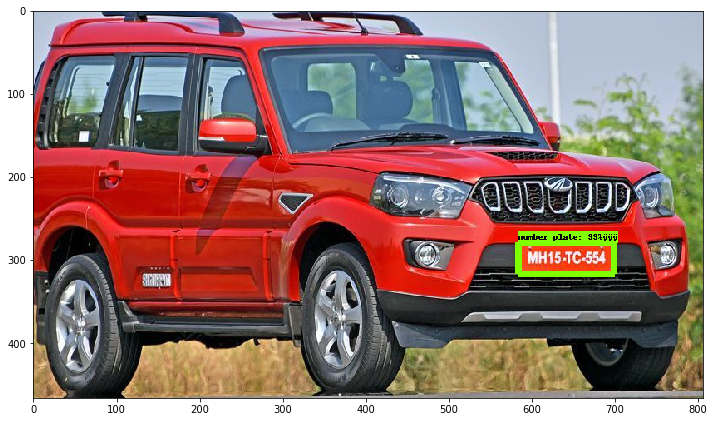

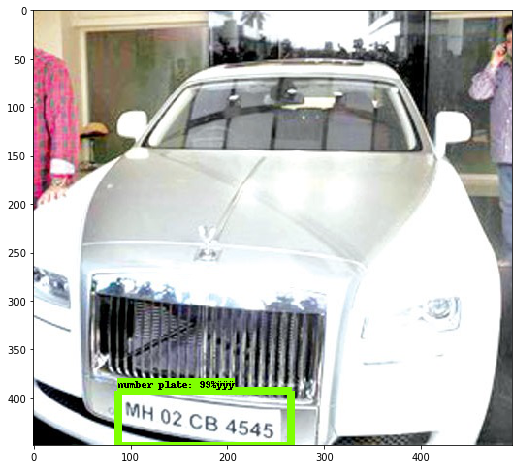

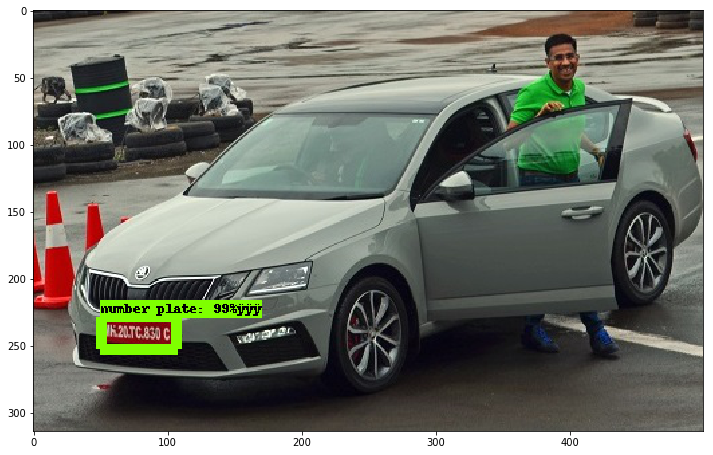

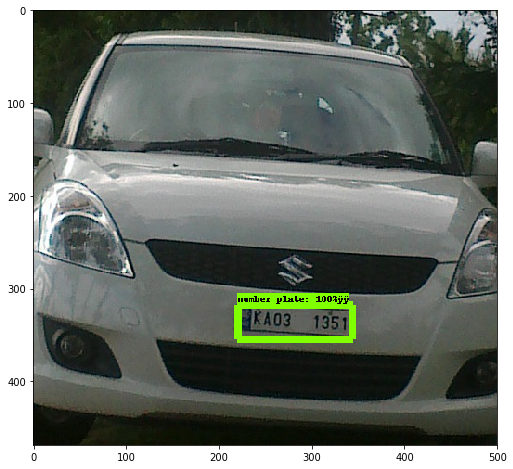

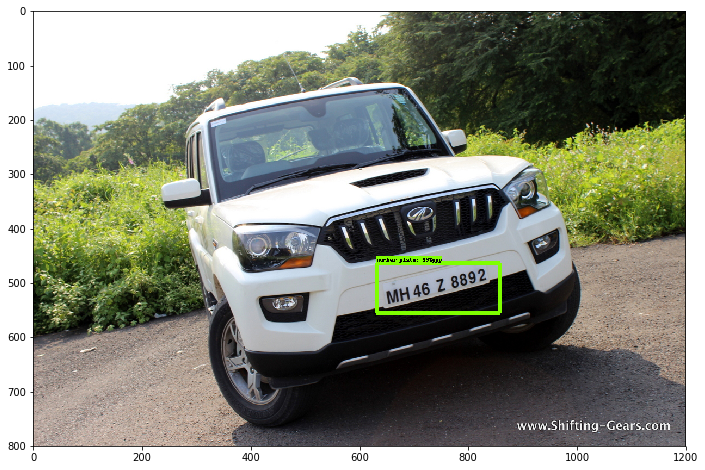

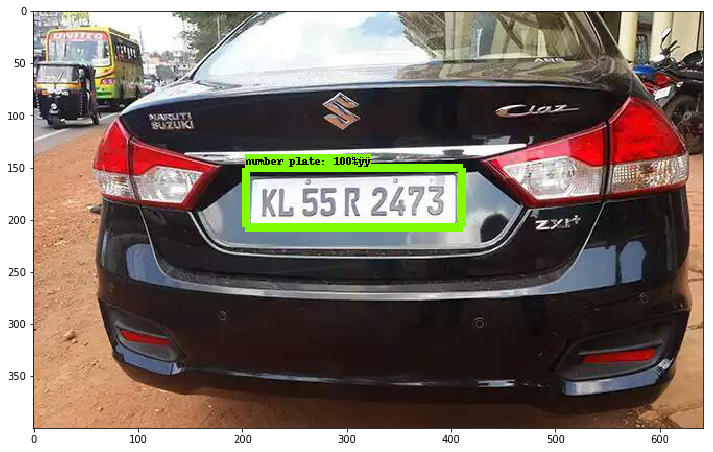

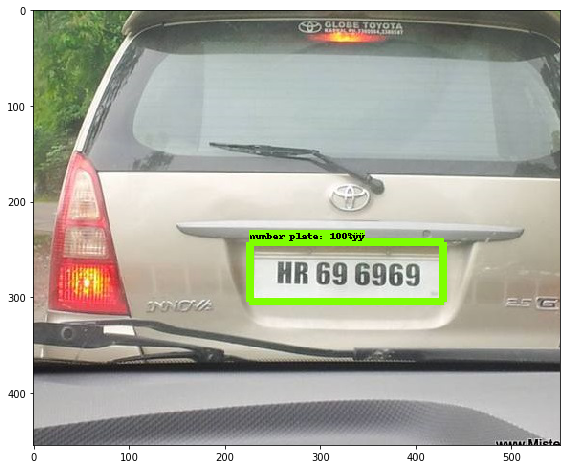

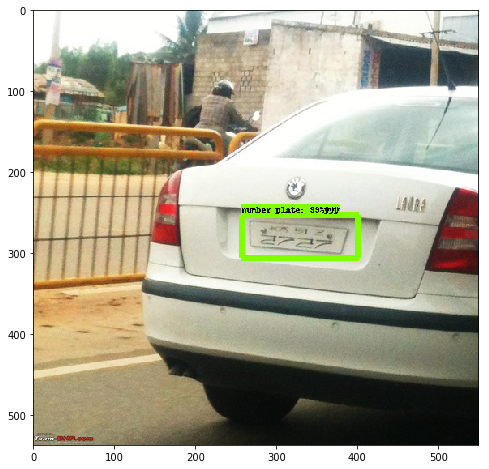

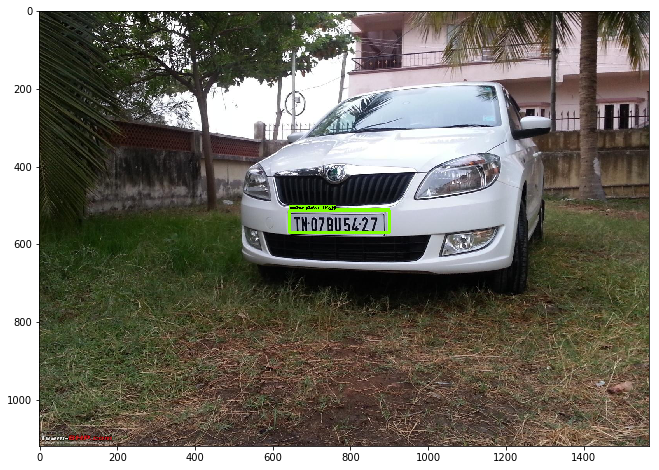

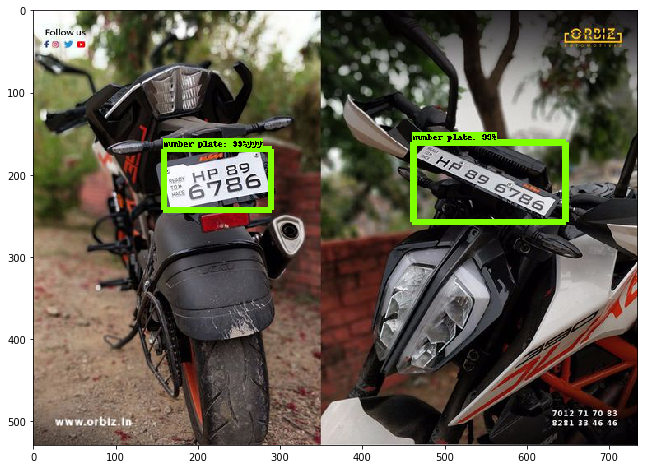

In [101]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

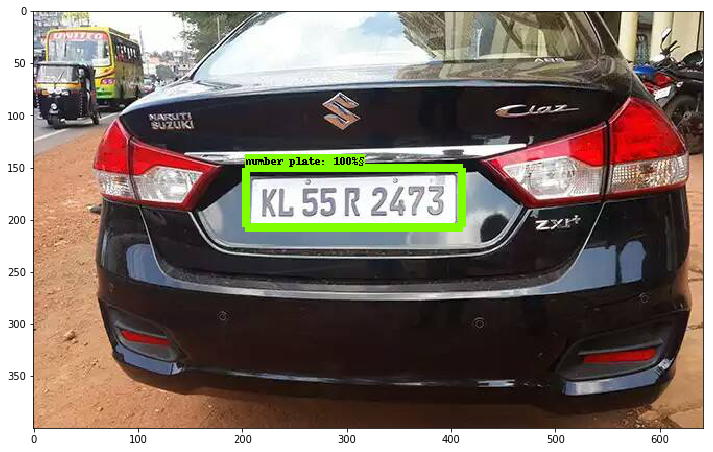

In [110]:
TEST_IMAGE_PATHS = ['test_images/6.jpeg']
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

image = Image.open(image_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

In [0]:
#Finding coordinates of detected boxes
boxes = np.squeeze(output_dict['detection_boxes'])
scores = np.squeeze(output_dict['detection_scores'])
#set a min thresh score, say 0.8
min_score_thresh = 0.8
bboxes = boxes[scores > min_score_thresh]

#get image size
im_width, im_height = image.size
final_box = []
for box in bboxes:
    ymin, xmin, ymax, xmax = box
    final_box.append([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])

In [0]:
img_height, img_width, img_channel = image_np.shape
absolute_coord = []
THRESHOLD = 0.7 # adjust your threshold here
N = len(output_dict['detection_boxes'])
for i in range(N):
    if output_dict['detection_scores'][i] < THRESHOLD:
        continue
    box = output_dict['detection_boxes']
    x_up = int(xmin*img_width)
    y_up = int(ymin*img_height)
    x_down = int(xmax*img_width)
    y_down = int(ymax*img_height)
    absolute_coord.append((x_up,y_up,x_down,y_down))
bounding_box_img = []
for c in absolute_coord:
    bounding_box_img.append(image_np[c[1]:c[3], c[0]:c[2],:])

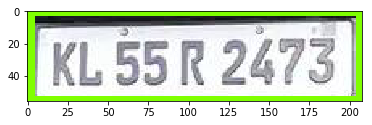

In [113]:
#Cropping and Displaying the number plate
number_plate = Image.fromarray(image_np[c[1]:c[3], c[0]:c[2],:])
number_plate.save('/content/number_plate.jpeg')
plt.imshow(number_plate)

In [0]:
#Necessary packages for Tesseract
!pip install pytesseract
!sudo apt-get install pillow
!sudo apt-get install tesseract-ocr

In [115]:
#Recognizing characters and numbers in the plate
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

image_path_in_colab='/content/number_plate.jpeg'
details = pytesseract.image_to_string(Image.open(image_path_in_colab))
# define punctuation
noise = '''!()-[]{};:'""\,<>./?@#$%^&*_~'''

# remove punctuation from the string
final_characters = ""
for char in details:
   if char not in noise:
       final_characters = final_characters + char

# display the unpunctuated string
print(final_characters)

KL55R 2473
